In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score

from tqdm.auto import tqdm

In [2]:
# read csv file
df = pd.read_csv("data/AER_credit_card_data.csv")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [4]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [5]:
# Create the target variable by mapping yes to 1 and no to 0.
df.card = (df.card == 'yes').astype(int)

In [6]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int64  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 123.8+ KB


In [8]:
# train / test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

### Q1: Feature with highest ROC AUC

In [9]:
num_vars = ['reports', 'dependents', 'active', 'share']

for i in num_vars:
    model = LogisticRegression()
    model.fit(df_train[i].array.reshape(-1, 1), y_train)
    y_pred = model.predict_proba(df_val[i].array.reshape(-1, 1))[:, 1]
    print(i, roc_auc_score(y_val, y_pred))

reports 0.7136725386747742
dependents 0.46847894125011175
active 0.5479746043101136
share 0.9856925690780649


### Q2: AUC of the model 

In [10]:
vars_model = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [11]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[vars_model].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
val_dict = df_val[vars_model].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr).round(3)

0.995

### Q3: Where precision and recall meet?

In [13]:
thresholds = np.arange(0.0, 1.01, 0.01)

scores_p = []
scores_r = []

for t in thresholds:
    precision = precision_score(y_val, y_pred >= t)
    recall = recall_score(y_val, y_pred >= t)
    print('%.2f %.3f %.3f' % (t, precision, recall))
    scores_p.append(precision)
    scores_r.append(recall)

0.00 0.799 1.000
0.01 0.861 1.000
0.02 0.872 1.000
0.03 0.898 1.000
0.04 0.906 1.000
0.05 0.906 1.000
0.06 0.917 1.000
0.07 0.917 1.000
0.08 0.921 0.995
0.09 0.921 0.995
0.10 0.925 0.995
0.11 0.925 0.995
0.12 0.925 0.995
0.13 0.950 0.995
0.14 0.959 0.986
0.15 0.959 0.986
0.16 0.967 0.986
0.17 0.967 0.986
0.18 0.972 0.981
0.19 0.976 0.981
0.20 0.976 0.981
0.21 0.976 0.981
0.22 0.976 0.981
0.23 0.976 0.981
0.24 0.976 0.976
0.25 0.976 0.976
0.26 0.976 0.976
0.27 0.976 0.976
0.28 0.976 0.976
0.29 0.976 0.976
0.30 0.976 0.972
0.31 0.981 0.972
0.32 0.981 0.972
0.33 0.981 0.972
0.34 0.990 0.972
0.35 0.995 0.972
0.36 0.995 0.972
0.37 0.995 0.972
0.38 0.995 0.972
0.39 0.995 0.972
0.40 0.995 0.972
0.41 0.995 0.972
0.42 0.995 0.967
0.43 0.995 0.967
0.44 0.995 0.967
0.45 0.995 0.967
0.46 0.995 0.967
0.47 0.995 0.967
0.48 0.995 0.967
0.49 0.995 0.967
0.50 0.995 0.967
0.51 0.995 0.967
0.52 0.995 0.967
0.53 0.995 0.967
0.54 0.995 0.967
0.55 0.995 0.967
0.56 0.995 0.967
0.57 0.995 0.967
0.58 0.995 0.9

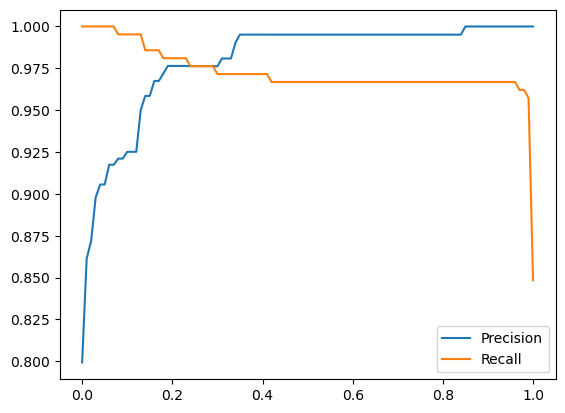

In [14]:
plt.plot(thresholds, scores_p, label='Precision')
plt.plot(thresholds, scores_r, label='Recall')
plt.legend();

### Q4: F1 score

In [15]:
thresholds = np.arange(0.0, 1.01, 0.01)

scores = []

for t in thresholds:
    f1 = f1_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, f1))
    scores.append(f1)

0.00 0.888
0.01 0.925
0.02 0.932
0.03 0.946
0.04 0.950
0.05 0.950
0.06 0.957
0.07 0.957
0.08 0.957
0.09 0.957
0.10 0.959
0.11 0.959
0.12 0.959
0.13 0.972
0.14 0.972
0.15 0.972
0.16 0.977
0.17 0.977
0.18 0.976
0.19 0.979
0.20 0.979
0.21 0.979
0.22 0.979
0.23 0.979
0.24 0.976
0.25 0.976
0.26 0.976
0.27 0.976
0.28 0.976
0.29 0.976
0.30 0.974
0.31 0.976
0.32 0.976
0.33 0.976
0.34 0.981
0.35 0.983
0.36 0.983
0.37 0.983
0.38 0.983
0.39 0.983
0.40 0.983
0.41 0.983
0.42 0.981
0.43 0.981
0.44 0.981
0.45 0.981
0.46 0.981
0.47 0.981
0.48 0.981
0.49 0.981
0.50 0.981
0.51 0.981
0.52 0.981
0.53 0.981
0.54 0.981
0.55 0.981
0.56 0.981
0.57 0.981
0.58 0.981
0.59 0.981
0.60 0.981
0.61 0.981
0.62 0.981
0.63 0.981
0.64 0.981
0.65 0.981
0.66 0.981
0.67 0.981
0.68 0.981
0.69 0.981
0.70 0.981
0.71 0.981
0.72 0.981
0.73 0.981
0.74 0.981
0.75 0.981
0.76 0.981
0.77 0.981
0.78 0.981
0.79 0.981
0.80 0.981
0.81 0.981
0.82 0.981
0.83 0.981
0.84 0.981
0.85 0.983
0.86 0.983
0.87 0.983
0.88 0.983
0.89 0.983
0.90 0.983

### Q5: Standard deviation with KFold

In [16]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[vars_model].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [17]:
def predict(df, dv, model):
    dicts = df[vars_model].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [19]:
np.std(scores).round(3)

0.003

### Q6: Best C

In [20]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003
